In [1]:
import math, sys, os
import time
import matplotlib.pyplot as plt
import numpy as np

sys.path.insert(0, os.path.join(os.getcwd(), 'src'))
from plotter import *
from kalman import *
from motion import *
from timer import *

%matplotlib notebook

In [2]:
# Import tdmclient Notebook environment:
import tdmclient.notebook
await tdmclient.notebook.start()

In [3]:
%%run_python

state = 1

@onevent
def move(speed_left, speed_right):
    global motor_left_target, motor_right_target, state
    if state == 1 :
        motor_left_target = speed_left
        motor_right_target = speed_right
    
@onevent 
def button_center():
    global state, motor_left_target, motor_right_target
    state = 0
    motor_left_target = 0
    motor_right_target = 0

In [4]:
def send_command():
    if command[step][0] == command[step][1] and command[step][0] != 0:
        send_event("move", command[step][0] + 2, command[step][1] - 2)
    else :
        send_event("move", command[step][0], command[step][1])

In [5]:
@tdmclient.notebook.sync_var
def get_speed():
    return motor_left_speed, motor_right_speed

def kalman_call():
    global step, x_est, start, rt
    
    if step < len(command) :
        #retrieves the command that was applied Ts seconds ago
        speed_left = command[step][0]
        speed_right = command[step][1]
        
        #gets the right matrix corresponding to the command :
        #Thymio goes forward
        if speed_left == speed_right :
            A = A_F

        #Thymio is rotating
        else :
            A = A_R
            
        #measures the speed of the robot
        meas_speed_left,  meas_speed_right = get_speed()
        
        meas_pos = []
        if camera_on :
            #get the last measured position
            meas_pos = camera_pos[step + 1]
            

        #computes the estimated states
        new_x_est, new_P_est = kalman_filter(meas_pos, meas_speed_left, meas_speed_right, x_est[-1], P_est[-1], A, camera_on)

        x_est.append(new_x_est)
        P_est.append(new_P_est)

        step += 1

        if step < len(command) :
            send_command()
    else :
        rt.stop()

In [6]:
def simulate_camera():
    
    camera_pos.append(np.array([[500], [500], [0]]))
    
    for i in range(len(command)) :
        #retrieves the command that was applied Ts seconds ago
        speed_left = command[i][0]
        speed_right = command[i][1]
        
        speed_trans = (speed_left + speed_right) * thymio_speed_to_mms / 2
        speed_rot =  (speed_right - speed_left) * thymio_speed_to_rads / 2
        
        theta = camera_pos[-1][2]
        x_dot = speed_trans * np.cos(theta)
        y_dot = speed_trans * np.sin(theta)
        theta_dot = [speed_rot]
        
        #gets the right matrix corresponding to the command :
        #Thymio goes forward
        if speed_left == speed_right :
            A = A_F

        #Thymio is rotating
        else :
            A = A_R
            
        x_next = np.dot(A, np.array([camera_pos[-1][0], camera_pos[-1][1], camera_pos[-1][2], x_dot, y_dot, theta_dot]))
        camera_pos.append(x_next[:3])                        
                                

<IPython.core.display.Javascript object>


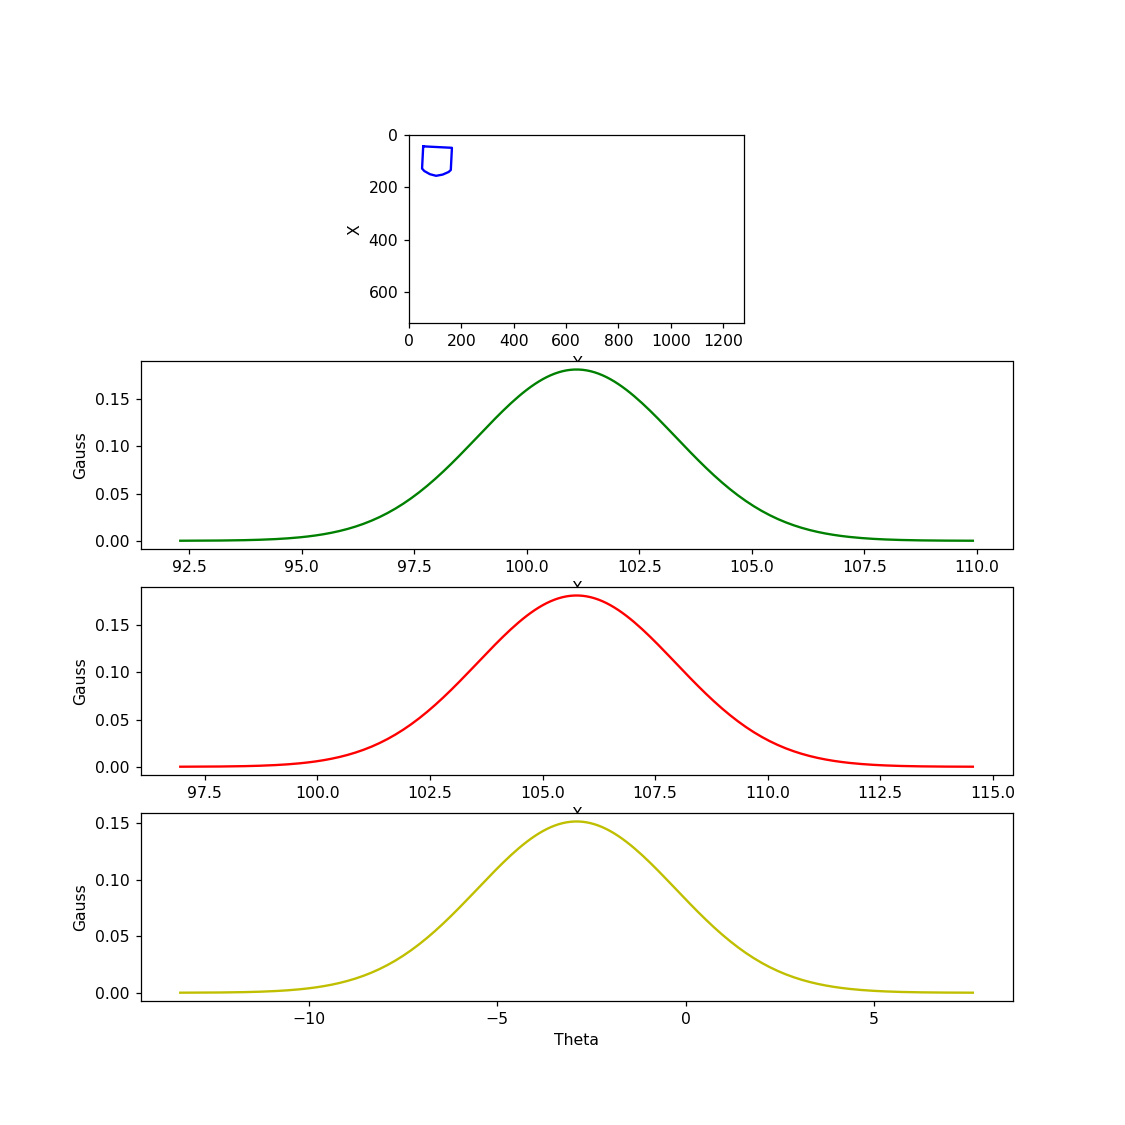

In [7]:
camera_on = False

#initial state, robot stopped :
if camera_on :
    x0 = 0
    y0 = 0
    theta0 = 0

    x_dot0 = 0 
    y_dot0 = 0
    theta_dot0 = 0 
    
else :
    x0 = 100
    y0 = 100
    theta0 = 0

    x_dot0 = 0 
    y_dot0 = 0
    theta_dot0 = 0 

x_est = [np.array([[x0], [y0], [theta0], [x_dot0], [y_dot0], [theta_dot0]])]

if camera_on :
    P_est = [1000 * np.diag(np.ones(6))]
    
else :
    P_est = [np.diag(np.array([2**2, 2**2, (2 * (math.pi/180)) ** 2, 0, 0, 0]))]

step = 0
command = turn_left(math.pi/2) + move_forward(30) +  move_backward(30) + turn_right(math.pi/2) + [[0, 0]]

if camera_on :
    camera_pos = []
    simulate_camera()

#start Kalman
send_command()
rt = RepeatedTimer(Ts, kalman_call)


fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(4,1,1)
ax2 = fig.add_subplot(4,1,2)
ax3 = fig.add_subplot(4,1,3)
ax4 = fig.add_subplot(4,1,4)


while step < len(command):
    plot(ax1, ax2, ax3, ax4, x_est, P_est, fig)
    #time.sleep(0.1)
    
plot(ax1, ax2, ax3, ax4, x_est, P_est, fig)

